In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
# from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error, r2_score

In [10]:
# Load the data from the CSV file
df = pd.read_csv("../datasets/kangaroo-cleaned.csv")

# Display the first few rows to verify the data was loaded correctly
df.head(1)

,subtype,bedroomCount,bathroomCount,habitableSurface,hasDressingRoom,buildingCondition,buildingConstructionYear,facedeCount,hasLift,heatingType,...,hasArmoredDoor,hasVisiophone,hasOffice,toiletCount,hasSwimmingPool,hasFireplace,hasTerrace,terraceSurface,price,epc_kwh
0,HOUSE,4.0,2.0,270.0,0,1.0,1910.0,2.0,0,3.0,...,0,0,1,3.0,0,0,1,1.0,895000.0,325.0


Get relevant features 

In [11]:
# Calculate the correlation matrix, excluding propertyId
correlation_matrix = df.drop(columns=['subtype']).corr()
price_correlations = correlation_matrix['price'].abs().sort_values(ascending=False)

features = price_correlations[price_correlations > 0.09].index.tolist() #list top correlated features 
features = features[1:] # remove price from the list of features

features

['habitableSurface',
 'toiletCount',
 'bedroomCount',
 'bathroomCount',
 'landSurface',
 'epc_kwh',
 'buildingCondition',
 'kitchenType',
 'hasVisiophone',
 'buildingConstructionYear',
 'hasOffice',
 'facedeCount',
 'hasSwimmingPool',
 'hasFireplace',
 'gardenSurface',
 'hasDressingRoom',
 'hasThermicPanels',
 'hasTerrace',
 'heatingType',
 'terraceSurface',
 'hasPhotovoltaicPanels',
 'livingRoomSurface']

Prepare for regression + Standardize scales

In [12]:
target = 'price'

x = df[features]
y = df[target]

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Scale features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

---
## Option 1: Linear Regression Coefficients (for linear relationships)

<Axes: title={'center': 'Linear Regression Feature Importance'}>

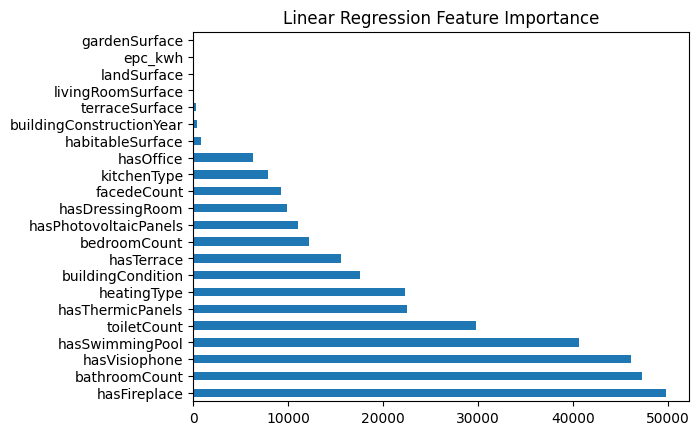

In [13]:
lr = LinearRegression()
lr.fit(X_train, y_train)

# Get importance from coefficients (absolute values give relative importance)
importance = pd.Series(np.abs(lr.coef_), index=features)
importance.sort_values(ascending=False).plot(kind='barh', title='Linear Regression Feature Importance')

## Evaluate Model

In [14]:
y_pred = lr.predict(X_test)
print("RMSE:", root_mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))
print("MAPE:", np.mean(np.abs((y_test - y_pred) / y_test)) * 100, "%")

RMSE: 132412.6444028084
R² Score: 0.5347884402321956
MAPE: 27.206271521279508 %


---

## Option 2: Random Forest Feature Importance (handles non-linear relationships)

<Axes: title={'center': 'Random Forest Feature Importance'}>

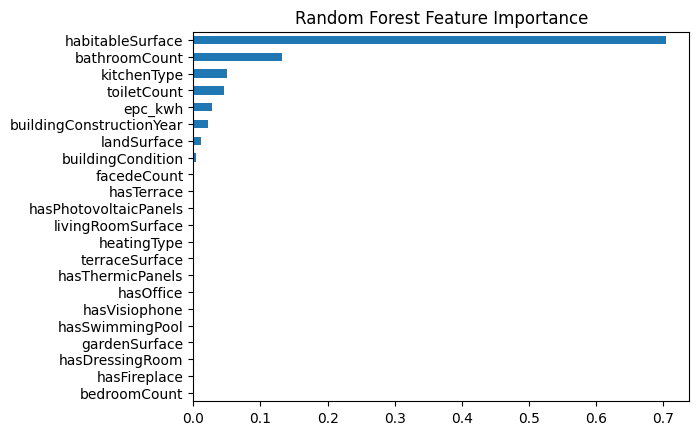

In [15]:
rf = RandomForestRegressor(n_estimators=100, max_depth=3, min_samples_leaf=5, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
importance = pd.Series(rf.feature_importances_, index=features)
importance.sort_values(ascending=True).plot(kind='barh', title='Random Forest Feature Importance')

### Evaluate Model

In [16]:
y_pred = rf.predict(X_test)
print("RMSE:", root_mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))
print("MAPE:", np.mean(np.abs((y_test - y_pred) / y_test)) * 100, "%")

RMSE: 147993.2524488328
R² Score: 0.41886717176973665
MAPE: 31.54712416724676 %
